In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [91]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [92]:
train_df = pd.read_csv('../data/cleaned_gc_data/gc_train.csv', index_col= 'Unnamed: 0')
test_df = pd.read_csv('../data/cleaned_gc_data/gc_test.csv', index_col= 'Unnamed: 0')

In [93]:
train_df.head()

,secs,power,hr,cad
0,4,33.4,76.0,28.2
1,5,57.4,77.0,39.6
2,6,80.8,78.0,47.4
3,7,100.6,79.0,56.0
4,8,111.4,80.0,59.6


In [94]:
test_df.head()

,secs,power,hr,cad
0,4,98.4,98.0,77.0
1,5,112.2,100.0,77.4
2,6,118.0,100.0,78.2
3,7,126.0,100.0,79.6
4,8,137.0,100.2,80.8


In [95]:
# Scaling the data
mm_scaler = MinMaxScaler()
train_data_scaled = mm_scaler.fit_transform(train_df)
test_data_scaled = mm_scaler.fit_transform(test_df)

In [96]:
pd.DataFrame(train_data_scaled)

,0,1,2,3
0,0.000000,0.047578,0.222222,0.173645
1,0.000161,0.081766,0.229938,0.243842
2,0.000322,0.115100,0.237654,0.291872
3,0.000483,0.143305,0.245370,0.344828
4,0.000644,0.158689,0.253086,0.366995
...,...,...,...,...
109912,0.559742,0.000000,0.348765,0.000000
109913,0.559903,0.000000,0.345679,0.000000
109914,0.560064,0.000000,0.342593,0.000000
109915,0.560225,0.000000,0.339506,0.000000


In [97]:
# X = data_scaled
# y = data_scaled[:,3] # HR is the target

In [98]:
# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle= False, random_state = 42)
X_train = train_data_scaled
X_test = test_data_scaled
y_train = train_data_scaled[:,2]
y_test = test_data_scaled[:,2]


In [99]:
X_train.shape

(109917, 4)

In [100]:
X_test.shape

(20439, 4)

In [101]:
y_train.shape

(109917,)

In [102]:
y_test.shape

(20439,)

In [103]:
win_length = 70
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [104]:
train_generator[0][0].shape

(32, 70, 4)

In [105]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [106]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 70, 128)           68096     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 70, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 70, 128)           131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 70, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [107]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 3,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 75,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/75
3433/3433 [==============================] - 60s 18ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 2/75
3433/3433 [==============================] - 60s 18ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/75
3433/3433 [==============================] - 60s 18ms/step - loss: 0.0012 - val_loss: 6.3893e-04
Epoch 4/75
3433/3433 [==============================] - 61s 18ms/step - loss: 6.9680e-04 - val_loss: 7.8637e-04
Epoch 5/75
3433/3433 [==============================] - 59s 17ms/step - loss: 5.6278e-04 - val_loss: 9.0747e-04
Epoch 6/75
3433/3433 [==============================] - 59s 17ms/step - loss: 5.2420e-04 - val_loss: 3.6643e-04
Epoch 7/75
3433/3433 [==============================] - 61s 18ms/step - loss: 4.2558e-04 - val_loss: 2.8297e-04
Epoch 8/75
3433/3433 [==============================] - 59s 17ms/step - loss: 4.3377e-04 - val_loss: 7.5385e-04
Epoch 9/75
3433/3433 [==============================] - 61s 18ms/step - loss: 4.3196e-04 - val_loss: 4.9425e-04
Epoch 10/75


In [108]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [109]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9863843567067916, 0.9903731489994868)

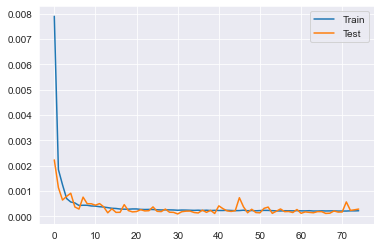

In [110]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
#plt.ylim(0, .03);

In [111]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [112]:
hr_test_results_sc[2] = test_preds

In [113]:
hr_test_results_sc.head(10)

,0,1,2,3
0,0.012870,0.290142,0.670048,0.657420
1,0.013054,0.294290,0.674582,0.653259
2,0.013238,0.264031,0.678464,0.640777
3,0.013422,0.247194,0.682101,0.639390
4,0.013605,0.244021,0.685860,0.638003
5,0.013789,0.254026,0.687679,0.636616
6,0.013973,0.259395,0.691440,0.633842
7,0.014157,0.279161,0.695919,0.633842
8,0.014341,0.281845,0.698481,0.629681
9,0.014525,0.272084,0.702213,0.626907


In [114]:
# Column '2' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

,0,1,2,3
0,74.0,237.8,141.664745,94.8
1,75.0,241.2,142.109007,94.2
2,76.0,216.4,142.489512,92.4
3,77.0,202.6,142.845899,92.2
4,78.0,200.0,143.214243,92.0
5,79.0,208.2,143.392570,91.8
6,80.0,212.6,143.761101,91.4
7,81.0,228.8,144.200101,91.4
8,82.0,231.0,144.451129,90.8
9,83.0,223.0,144.816861,90.4


In [115]:
# This is y_test, de-scaled (Original)
pd.DataFrame(test_df['hr'][win_length:]).reset_index().drop('index', axis= 1)

,hr
0,144.2
1,144.6
2,145.0
3,145.4
4,145.6
...,...
20364,96.0
20365,95.4
20366,95.0
20367,94.6


In [116]:
pd.DataFrame(test_df['power'][win_length:]).reset_index().drop('index', axis= 1) * .5

,power
0,118.9
1,120.6
2,108.2
3,101.3
4,100.0
...,...
20364,0.0
20365,0.0
20366,0.0
20367,0.0


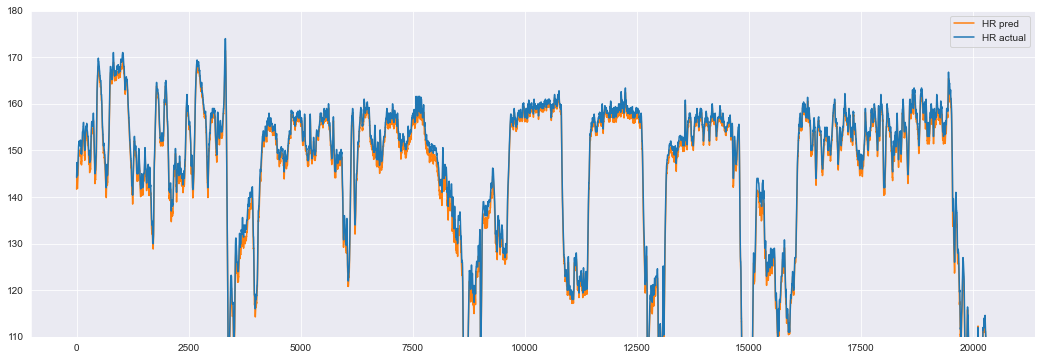

In [117]:
sns.set_style('darkgrid')

plt.figure(figsize= (18, 6))
plt.plot(hr_test_results[2], color = 'tab:orange', label= 'HR pred')
plt.plot(pd.DataFrame(test_df['hr'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'HR actual')
#plt.plot(pd.DataFrame(test_df['power'][win_length:]).reset_index().drop('index', axis= 1) * .5, color= 'tab:green', label= 'Power actual')
plt.ylim(110, 180)
#plt.xlim(0, 1000)
plt.legend();

In [118]:
# Save your model

model.save('../models/gc_lstm_model1/')

INFO:tensorflow:Assets written to: ../models/gc_lstm_model1/assets


In [119]:
# Reload model and test it
reconstructed_model = keras.models.load_model('../models/gc_lstm_model1/')

In [120]:
recon_train_preds = reconstructed_model.predict(train_generator)
recon_test_preds = reconstructed_model.predict(test_generator)

In [121]:
r2_score(y_train[win_length:], recon_train_preds), r2_score(y_test[win_length:], recon_test_preds)

(0.9863843567067916, 0.9903731489994868)

## Now try testing the model on individual workouts

In [122]:
test_1_df = pd.read_csv('../data/cleaned_gc_data/gc_test_1.csv', index_col= 'Unnamed: 0')

In [123]:
test_1_data_scaled = mm_scaler.fit_transform(test_1_df)

In [124]:
X_test_1 = test_1_data_scaled
y_test_1 = test_1_data_scaled[:,2]

In [125]:
X_test_1.shape

(3448, 4)

In [126]:
y_test_1.shape

(3448,)

In [127]:
# Create test sequences
test_1_generator = TimeseriesGenerator(X_test_1, y_test_1, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [128]:
test_1_preds = reconstructed_model.predict(test_1_generator)

In [129]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test_1[win_length:], test_1_preds)

(0.9863843567067916, 0.9687757761588923)

In [130]:
# Create a dataframe that corresponds to the X testing data that the model used
hr_test_1_results_sc = pd.DataFrame(X_test_1[win_length:])

In [131]:
# Replace the original y column with predictions for y
hr_test_1_results_sc[2] = test_1_preds 

In [132]:
# Restore all of the data to its original scale for interpretability
# Column '2' is y_test predictions, de-scaled
hr_test_1_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_1_results_sc))
hr_test_1_results.head()

,0,1,2,3
0,74.0,237.8,142.177008,94.8
1,75.0,241.2,142.547866,94.2
2,76.0,216.4,142.869171,92.4
3,77.0,202.6,143.186825,92.2
4,78.0,200.0,143.526884,92.0


In [133]:
# This is the original y_test (de-scaled)
pd.DataFrame(test_1_df['hr'][win_length:]).reset_index().drop('index', axis= 1)

,hr
0,144.2
1,144.6
2,145.0
3,145.4
4,145.6
...,...
3373,115.6
3374,113.8
3375,112.8
3376,112.2


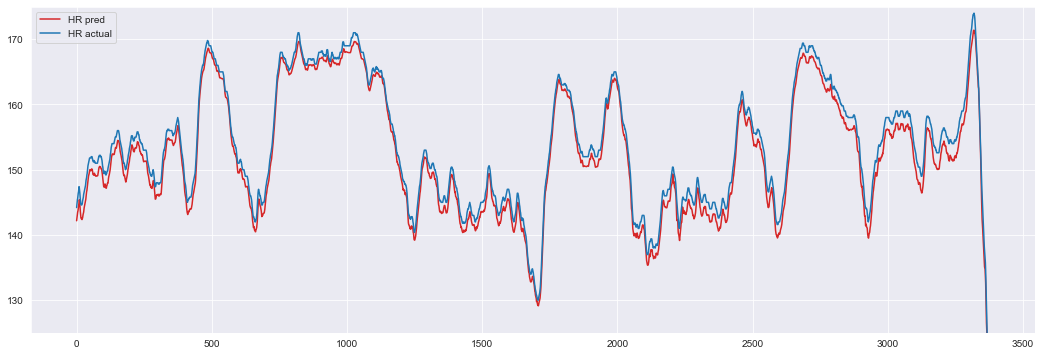

In [136]:
sns.set_style('darkgrid')

plt.figure(figsize= (18, 6))
plt.plot(hr_test_1_results[2], color = 'tab:red', label= 'HR pred')
plt.plot(pd.DataFrame(test_1_df['hr'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'HR actual')
#plt.plot(pd.DataFrame(test_1_df['power'][win_length:]).reset_index().drop('index', axis= 1) * .5, color= 'tab:green', label= 'Power actual')
plt.ylim(125, 175)
#plt.xlim(0, 1000)
plt.legend();